In [0]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

!pip install imutils
!pip install tensorflowjs

from imutils import paths

     |████████████████████████████████| 61kB 1.7MB/s 
     |████████████████████████████████| 92kB 4.0MB/s 
     |████████████████████████████████| 104.6MB 112kB/s 
     |████████████████████████████████| 450kB 29.3MB/s 
     |████████████████████████████████| 3.9MB 26.9MB/s 
     |████████████████████████████████| 256kB 35.5MB/s 
     |████████████████████████████████| 921kB 40.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d5e5bc4fd5100a57e491458e39fa2147eb49d27c846e5cdf11de7f3cc71680c8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=44d463c9d57b98c8c763a26bd2f36f1c3280487c20b57e556a2722dd695bc257
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built gast PyInquirer
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, b

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle/Dogs vs Cats

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle/Dogs vs Cats


In [0]:
!kaggle datasets download -d biaiscience/dogs-vs-cats
!unzip -qq \*.zip
%rm *.zip

 99% 809M/817M [00:17<00:00, 46.3MB/s]
100% 817M/817M [00:17<00:00, 47.7MB/s]


In [0]:
# Only pick 1000 samples by class and 400 aditional samples from each class as validation data
%%bash
rm -r data
mkdir -p data/train/dogs data/train/cats data/validation/dogs data/validation/cats data/test
find train/train -name 'dog.*' | head -1000 | xargs -I filename cp filename data/train/dogs
find train/train -name 'dog.*' | head -400 | xargs -I filename cp filename data/validation/dogs
find train/train -name 'cat.*' | head -1000 | xargs -I filename cp filename data/train/cats
find train/train -name 'cat.*' | head -400 | xargs -I filename cp filename data/validation/cats
cd '/content/gdrive/My Drive/Kaggle/Dogs vs Cats/test/test'
ls| head -30 | xargs -I filename cp filename ../../data/test
cd '/content/gdrive/My Drive/Kaggle/Dogs vs Cats'

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
batch_size = 16

input_shape = (img_width, img_height, 3)

In [0]:
# train augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# for testing only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
# build model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout

# load the VGG16 network, ensuring the head fully connected layer sets are left
model_vgg16_conv = VGG16(weights="imagenet", include_top=False)
# Make VGG16 model layers as non trainable
for layer in model_vgg16_conv.layers:
    layer.trainable = False

input = Input(shape=input_shape)
# use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

top_model = Flatten()(output_vgg16_conv)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

model = Model(inputs=input, outputs=top_model)

In [0]:
from keras.optimizers import SGD

model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

In [0]:
train_generator = train_datagen.flow_from_directory(
  'data/train',
  target_size=(150, 150),
  batch_size=batch_size,
  class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
  'data/validation',
  target_size=(150, 150),
  batch_size=batch_size,
  class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [0]:
epochs = 50

history = model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=epochs,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size
)

Epoch 1/50
125/125 [==============================] - 28s 226ms/step - loss: 0.6750 - accuracy: 0.5945 - val_loss: 0.5756 - val_accuracy: 0.7837
Epoch 2/50
125/125 [==============================] - 26s 208ms/step - loss: 0.5638 - accuracy: 0.7145 - val_loss: 0.4495 - val_accuracy: 0.8000
Epoch 3/50
125/125 [==============================] - 27s 212ms/step - loss: 0.5084 - accuracy: 0.7675 - val_loss: 0.4164 - val_accuracy: 0.8225
Epoch 4/50
125/125 [==============================] - 26s 206ms/step - loss: 0.4881 - accuracy: 0.7645 - val_loss: 0.3097 - val_accuracy: 0.8325
Epoch 5/50
125/125 [==============================] - 26s 207ms/step - loss: 0.4459 - accuracy: 0.8000 - val_loss: 0.3028 - val_accuracy: 0.8438
Epoch 6/50
125/125 [==============================] - 26s 208ms/step - loss: 0.4365 - accuracy: 0.7990 - val_loss: 0.3371 - val_accuracy: 0.8512
Epoch 7/50
125/125 [==============================] - 25s 203ms/step - loss: 0.4169 - accuracy: 0.8150 - val_loss: 0.4545 - val_ac

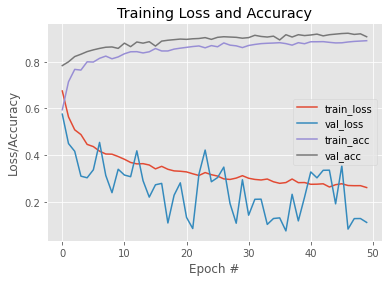

In [0]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

In [0]:
imagePaths = list(paths.list_images('data/test'))
X_test = []
# loop over the image paths
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (img_width, img_height))
    # update the data and labels lists, respectively
    X_test.append(image)

X_test = np.array(X_test) / 255.0 # normalize data

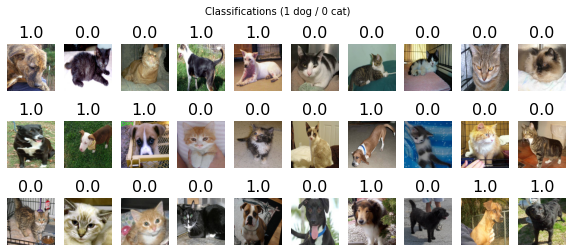

In [0]:
Y_predict = model.predict(X_test).reshape(-1)
Y_predict[Y_predict >= 0.5] = 1
Y_predict[Y_predict < 0.5] = 0
size = 30
rows = 3
f = plt.figure(figsize=(size // rows, rows + 1))
plt.suptitle("Classifications (1 dog / 0 cat)", fontsize=10)
for i in range(size):
    sp = f.add_subplot(rows, -(-size // rows), i + 1)
    sp.axis('Off')
    plt.imshow(X_test[i])
    sp.set_title(Y_predict[i], fontsize=16)

from google.colab import files
plt.savefig("dogs-vs-cats.png")
files.download("dogs-vs-cats.png")

In [0]:
%rm keras.h5
model.save('keras.h5')

In [0]:
%rm -r model
%mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/